### 3. Построение численной модели с учётом сопротивления воздуха.

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

g = 9.81

# Правая часть
def right(y, t, ang, a, b):
    angle = np.radians(ang)
    X, Y, Vx, Vy = y
    dvxdt = -a*np.sin(angle)*Vx - b*np.sin(angle)*np.sqrt(Vx**2 + Vy**2)*Vx
    dvydt = -np.sin(angle) - a*np.sin(angle)*Vy - b*np.sin(angle)*np.sqrt(Vx**2 + Vy**2)*Vy
    dxdt = Vx/(2*np.cos(angle))
    dydt = (2*Vy)/np.sin(angle)
    return [dxdt, dydt, dvxdt, dvydt]
# Решение
def solve_ODE(angle, a, b):
    # начальные условия
    Vx0 = np.cos(np.radians(angle))
    Vy0 = np.sin(np.radians(angle))
    y0 = 0
    x0 = 0
    
    y = [x0, y0, Vx0, Vy0] 
    t = np.linspace(0, 10, 10000)
    solution = odeint(right, y, t, args=(angle, a, b))
    # Находим индекс, когда значение y становится меньше нуля
    idx_zero_y = np.argmax(solution[:, 1] < 0)
    
    return solution[:idx_zero_y]

In [2]:
# Без сопротивления воздуха
angle = 30
a = 0
b = 0

sol_ODE = solve_ODE(angle, a, b)

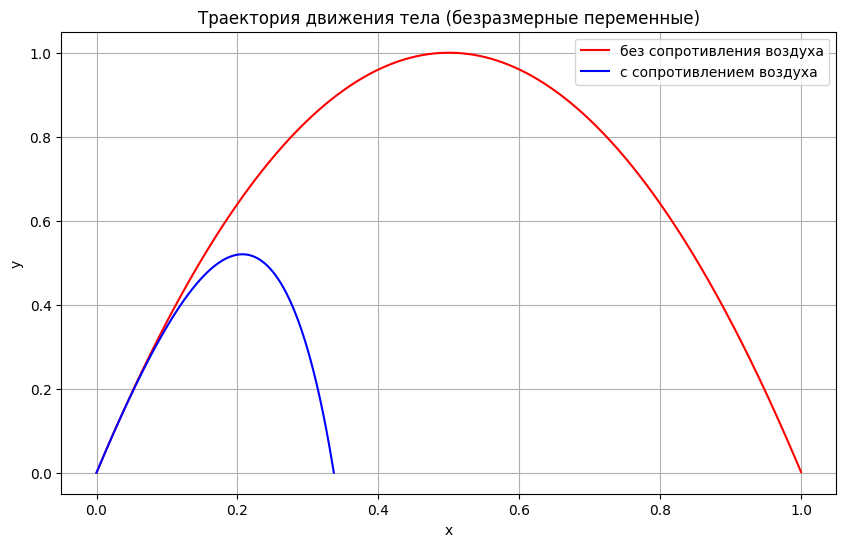

In [3]:
import pandas as pd
# Получение значения Q3
data = pd.read_csv('quartiles.csv')
q3_row = data[data['Quartile'] == 'Q3']
q3 = q3_row['Value'].values[0]

# Получение коэффициентов a и b
data = pd.read_csv('coeff.csv')
a1 = data['Slope'].values[0]
a2 = data['Intercept'].values[0]
b1 = data['Slope'].values[1]
b2 = data['Intercept'].values[1]

# С сопротивлением (3-й квантиль выборки)
v0 = q3
angle_1 = 30
a_1 = a1 * v0 + a2
b_1 = b1 * v0**2 + b2
sol_ODE_1 = solve_ODE(angle_1, a_1, b_1)

# Графики
plt.figure(figsize=(10, 6))
plt.plot(sol_ODE[:, 0], sol_ODE[:, 1], 'r', linewidth = 1.5, label = 'без сопротивления воздуха')
plt.plot(sol_ODE_1[:, 0], sol_ODE_1[:, 1],'b', linewidth = 1.5, label = 'с сопротивлением воздуха')
plt.title('Траектория движения тела (безразмерные переменные)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


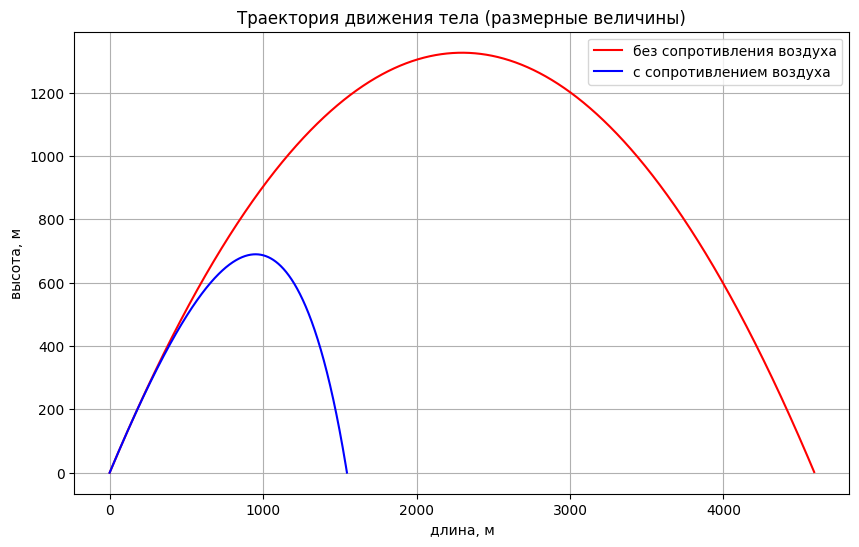

In [4]:
#Переход к размерным величинам
L = ((v0**2) * np.sin(np.radians(angle*2))) / g
H = ((v0**2) * np.sin(np.radians(angle))) / (2*g)

x = sol_ODE[:, 0] * L
y = sol_ODE[:, 1] * H
x1 = sol_ODE_1[:, 0] * L
y1 = sol_ODE_1[:, 1] * H

# Графики
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'r', linewidth = 1.5, label = 'без сопротивления воздуха')
plt.plot(x1, y1,'b', linewidth = 1.5, label = 'с сопротивлением воздуха')
plt.title('Траектория движения тела (размерные величины)')
plt.xlabel('длина, м')
plt.ylabel('высота, м')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
f = open('results.txt','w', encoding = 'utf-8')
# Дальность полета с учетом сопротивления
L_res = L * max(sol_ODE_1[:, 0])
f.write(f'Дальность полета с учетом сопротивления: {L_res:.2f} м\n')

# Высота полета с учетом сопротивления
H_max = H * max(sol_ODE_1[:, 1])
f.write(f'Высота полета с учетом сопротивления: {H_max:.2f} м\n')

# Время полета
T = (2*v0 * np.sin(np.radians(angle))) / g
f.write(f'Время полета: {T:.2f} с\n')

# Время, необходимое для подъёма на максимальную высоту
t = (v0 * np.sin(np.radians(angle))) / g
f.write(f'Время, необходимое для подъёма на максимальную высоту: {t:.2f} с\n')

# Модуль скорости в момент падения
sol = sol_ODE_1*v0
down = sol[sol[:, 3]< 0]
vx = down[:, 2]
vy = down[:, 3]
v_0 = np.sqrt(vx[0]**2 + vy[0]**2)
mod_v = np.sqrt(v_0**2 + (g*t)**2)
f.write(f'Модуль скорости в момент падения: {mod_v:.2f} м/c')

f.close()


In [20]:
with open('results.txt', encoding = 'utf-8') as f:
    print(f.read())

Дальность полета с учетом сопротивления: 1546.49 м
Высота полета с учетом сопротивления: 689.62 м
Время полета: 23.25 с
Время, необходимое для подъёма на максимальную высоту: 11.63 с
Модуль скорости в момент падения: 144.66 м/c
